## 빅데이터 활용 AI 설계
# CGAN : Conditional GAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

X_train.shape

(60000, 28, 28)

In [5]:
X_train = X_train/255
X_train = X_train[:,:,:,np.newaxis]

X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [35]:
y_train.shape

(60000,)

### Descriminator 정의

In [18]:
from keras.models import Model
from keras.layers import Input, Embedding, Reshape, Concatenate, Conv2D, \
        LeakyReLU, Flatten, Dropout, Dense, Conv2DTranspose
from keras.optimizers import Adam

In [52]:
in_label = Input((1,))
x_label = Embedding(10, 50)(in_label)
x_label = Dense(28*28)(x_label)
x_label = Reshape((28,28,1))(x_label) # 0~9 의 레이블을 받아들여서 28*28 인 채널을 하나 생성함

in_image = Input((28,28,1))

x = Concatenate()([in_image, x_label]) # 흑백이미지는 채널이 1, 레이블 채널을 추가해서 채널이 2가 됨

x # (?, 28, 28, 2)

<tf.Tensor 'concatenate_11/concat:0' shape=(?, 28, 28, 2) dtype=float32>

In [53]:
x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)

output = Dense(1, activation='sigmoid')(x)

discriminator = Model([in_image, in_label], output)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['acc'])

discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 50)        500         input_22[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 1, 784)       39984       embedding_12[0][0]               
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_16

### Generator 정의

In [54]:
in_label = Input((1,))
x_label = Embedding(10, 50)(in_label)
x_label = Dense(7*7)(x_label)
x_label = Reshape((7,7,1))(x_label) # 0~9 의 레이블을 받아들여서 7*7 인 채널을 하나 생성함

in_latent = Input((100,))
x_latent = Dense(7*7*128)(in_latent)
x_latent = LeakyReLU(alpha=0.2)(x_latent)
x_latent = Reshape((7,7,128))(x_latent)

x = Concatenate()([x_latent, x_label]) # (7,7,128) 생성 이미지층과 (7,7,1) 레이블 층을 결합

x # (?, 7, 7, 129)

<tf.Tensor 'concatenate_12/concat:0' shape=(?, 7, 7, 129) dtype=float32>

In [55]:
x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

output = Conv2D(1, (7,7), activation='sigmoid', padding='same')(x)  # why tanh not sigmoid?

generator = Model([in_latent, in_label], output)

In [56]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 6272)         633472      input_25[0][0]                   
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 50)        500         input_24[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

### Adversarial 정의

In [57]:
discriminator.trainable = False

#adversarial = Model([in_latent, in_label], discriminator([generator([in_latent, in_label]), in_label])
adversarial = Model([in_latent, in_label], discriminator([output, in_label]))
adversarial.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 6272)         633472      input_25[0][0]                   
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 50)        500         input_24[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

In [58]:
adversarial.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['acc'])

### 훈련

In [59]:
from keras.preprocessing import image

batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(100):
    indices = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[indices]
    real_labels = y_train[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    gen_labels = np.random.randint(10, size=batch_size)
    fake_images = generator.predict([gen_vectors, gen_labels])
    
    X = np.r_[real_images, fake_images] # [batch_size*2,28,28,1]
    y_label = np.r_[real_labels, gen_labels] # (batch_size*2,)
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch([X,y_label], y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    gen_labels2 = np.random.randint(10, size=(batch_size,1))
    ###########
    a_loss, a_acc = adversarial.train_on_batch([gen_vectors_2, gen_labels2], np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('cgan_images/fake_%05d.png' % (step+1))

C:\Anaconda3\envs\py36\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00001,  [0.6899303, 0.53125, 0.7329253, 0.0]
Step: 00002,  [0.6765008, 0.703125, 0.75929046, 0.0]
Step: 00003,  [0.6572873, 0.796875, 0.7875357, 0.0]
Step: 00004,  [0.6462057, 0.7890625, 0.82242084, 0.0]
Step: 00005,  [0.63395214, 0.796875, 0.85622275, 0.0]
Step: 00006,  [0.61893356, 0.875, 0.895667, 0.0]
Step: 00007,  [0.6071257, 0.84375, 0.929701, 0.0]
Step: 00008,  [0.59555155, 0.8359375, 0.9574631, 0.0]
Step: 00009,  [0.58315945, 0.8828125, 0.99115694, 0.0]
Step: 00010,  [0.57372993, 0.9453125, 1.0109124, 0.0]
Step: 00011,  [0.56745654, 0.9453125, 1.0099661, 0.0]
Step: 00012,  [0.5669149, 0.9609375, 0.98432416, 0.0]
Step: 00013,  [0.5693575, 0.984375, 0.94878495, 0.0]
Step: 00014,  [0.56769395, 1.0, 0.9080099, 0.0]
Step: 00015,  [0.5687106, 1.0, 0.851561, 0.0]
Step: 00016,  [0.5739318, 1.0, 0.8088491, 0.0]
Step: 00017,  [0.57351345, 1.0, 0.7779039, 0.0]
Step: 00018,  [0.5569184, 1.0, 0.7570441, 0.0]
Step: 00019,  [0.5526495, 1.0, 0.73965716, 0.0]
Step: 00020,  [0.5307945, 1.0

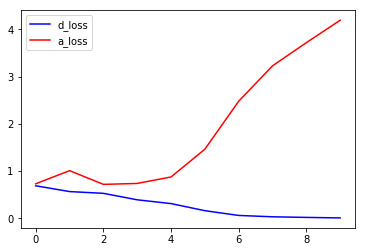

In [60]:
plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.legend()

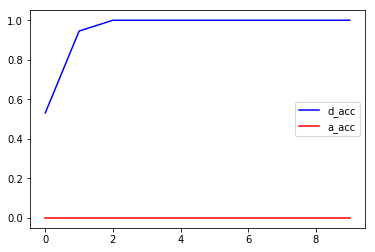

In [61]:
plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()